Create a pipeline by defining a number of functions which will:

1) explore, train and test a SARIMA model by using a series of an endogenous variable,

2) train and test a SARIMAX model by using a series of an endogenous variable and an exogenous variable, 

3) validation: return the predictions and observations of the two models above for the test set,

4) return the plot of the predictions and observations of the two models and their RMSE (root-mean-squared error) values.

In [1]:
# Check the versions of key python libraries for time series forecasting
# Import all relevant libraries related to time series forecasting and data visualization

# Check the versions of key python libraries for time series forecasting
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
import datetime

# Load specific time series forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from statsmodels.tsa.stattools import adfuller               # for the ADF statistic
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error               
from math import sqrt

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Import tools and settings for data visualization
import itertools
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
print('All imports done!')

scipy: 1.3.1
numpy: 1.17.2
matplotlib: 3.0.3
pandas: 0.25.1
statsmodels: 0.10.1
sklearn: 0.21.3
All imports done!


In [57]:
# Load the dataset for the number of incidents
incidents_grouped=pd.read_csv('incidents_grouped.csv', header=None, index_col=0)
incidents_grouped.shape

(1095, 1)

In [56]:
# Load the most important weather-related feature for the san diego lindbergh field station
sdlf = pd.read_csv('sdlf_weather_feature.csv', header=None, squeeze=True)
sdlf.shape

(1095,)

In [49]:
# Draw the decomposition plot of the data
# The input is a series indexed by dates 
def exploration(series,ylabel):
    # Make sure the index of the series is of type 'datetime'
    series.index.freq = 'D'
    series.index = pd.to_datetime(series.index)
    
    # Draw a line plot
    ylabel=ylabel
    xlabel='' # we don't really need a label here
    
    ax = series.plot(figsize=(16,5))
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel);
    
    # Draw a decomposition plot
    decomposition = seasonal_decompose(series, model='additive')
    fig = decomposition.plot()
    rcParams['figure.figsize'] = 18, 8
    plt.show()
    
    
    # Density plots of time series
    plt.figure(1)
    plt.subplot(211)
    series.hist(ax=plt.gca())
    plt.subplot(212)
    series.plot(kind='kde',ax=plt.gca())
    plt.show()
    
    X = series.values.flatten()
    X = X.astype('float32')
    # check if stationary
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('If the p-value is small and ADF statistic is lower than the critical values, the data is stationary.') 
    
    # ACF and PACF plots of time series
    plt.figure()
    plt.subplot(211)
    plot_acf(series, lags=30, ax=plt.gca())
    plt.subplot(212)
    plot_pacf(series, lags=30, ax=plt.gca())
    plt.show()

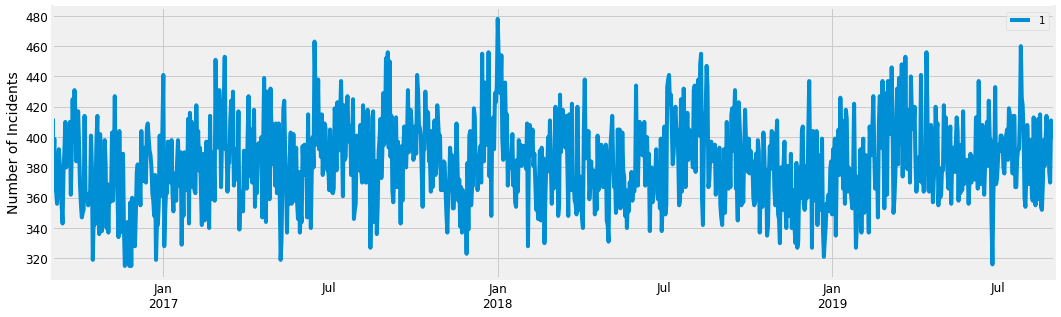

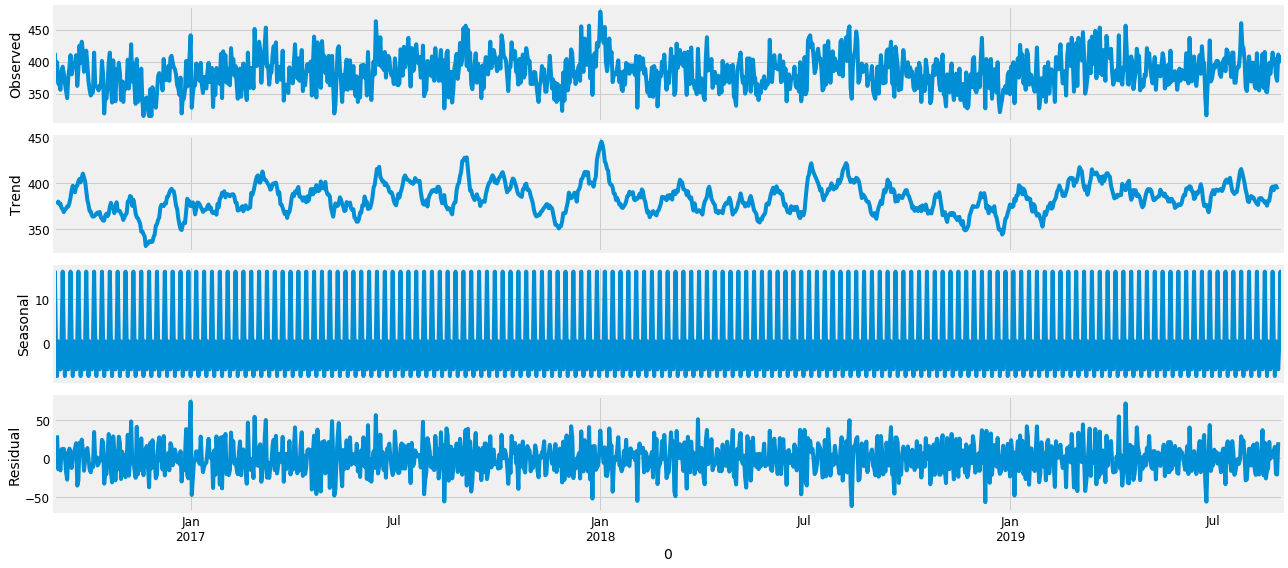

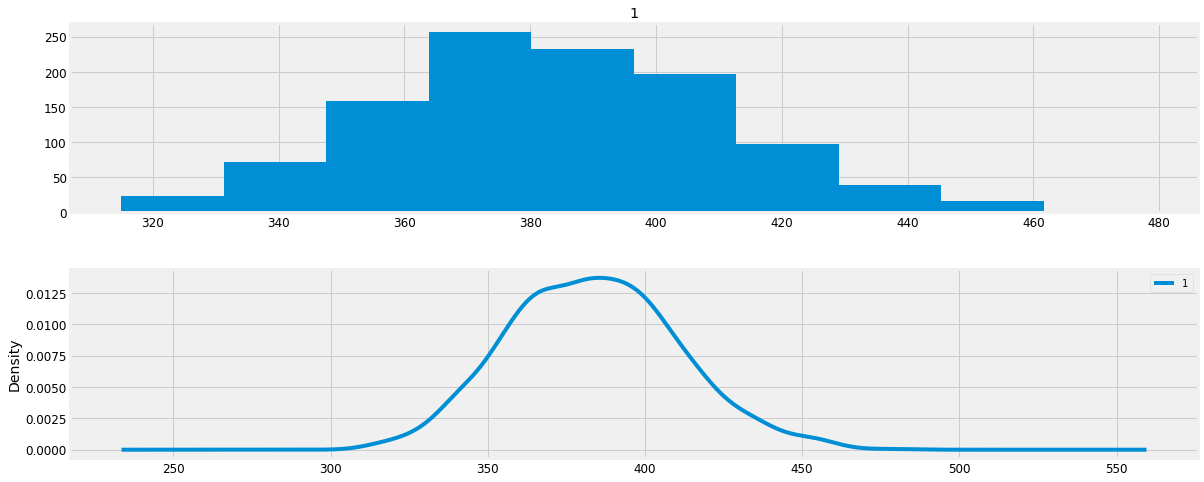

ADF Statistic: -6.765880
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
If the p-value is small and ADF statistic is lower than the critical values, the data is stationary.


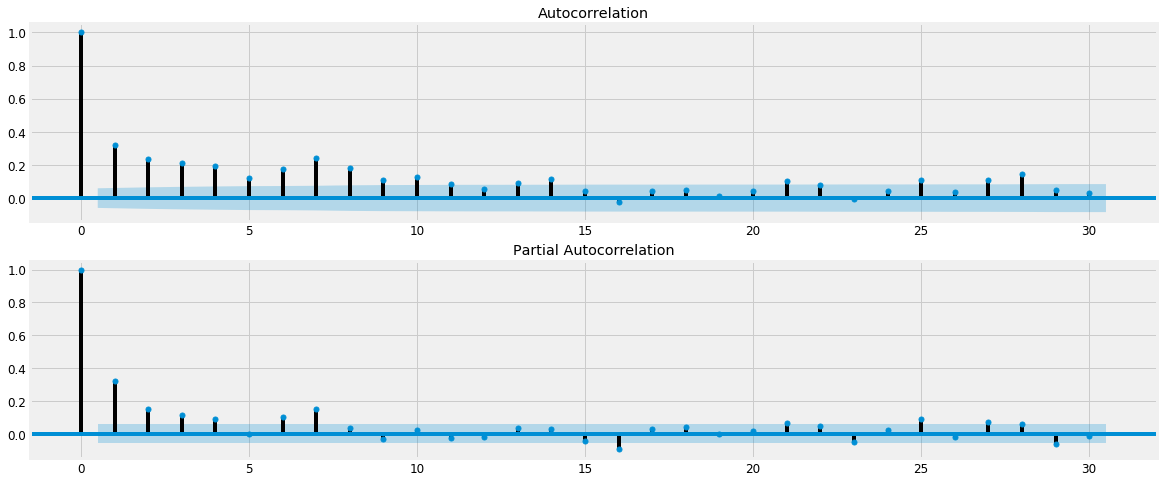

In [50]:
exploration(incidents_grouped,'Number of Incidents')

In [51]:
# Divide the time series to training, test and validation sets in the chronological order
def train_test_validation_split(series, name, validation_set, test_set):
    # validation_set: Number of rows in the validation set
    # test_set: Number of rows in the test set
    # name for the series to be used to name the csv files containing train, test and validation set 
    series = series.astype('float32')

    # Divide the series into a test set and the rest
    split_point = len(series) - test_set
    series_dataset, test = series[0:split_point], series[split_point:]
    
    train_size = len(series_dataset)-validation_set
    train, validation = series_dataset[0:train_size], series_dataset[train_size:]
    series_dataset.to_csv(name+'_train_validation.csv',index=False)
    train.to_csv(name+'_train.csv',index=False)
    test.to_csv(name+'_test.csv',index=False)
    validation.to_csv(name+'_validation.csv',index=False)
    return print('Training Set: %d, Validation Set: %d, Test Set: %d' % (len(train), len(validation), len(test)))

In [52]:
train_test_validation_split(incidents_grouped,'incidents',181,184)

Training Set: 730, Validation Set: 181, Test Set: 184


In [53]:
train_test_validation_split(sdlf,'temperature',181,184)

Training Set: 730, Validation Set: 181, Test Set: 184


In [62]:
def hyperparameter_tuning(endog_name,exog_name=None, m=7,scoring='mse', out_of_sample_size=181):
    # Load and shape endogenous data for hyperparameter tuning 
    endog=pd.read_csv(endog_name+'_train_validation.csv', header=0, squeeze=True)
    endog=endog.values.reshape(-1,1)
    
    # Load and shape exogenous data for hyperparameter tuning
    if exog_name!=None:
        exog=pd.read_csv(exog_name+'_train_validation.csv', header=None, squeeze=True)
        exog=exog.values.reshape(-1,1)
    else:
        exog=None    
    return auto_arima(endog, exogenous=exog, seasonal=True, out_of_sample_size=out_of_sample_size, m=m,scoring=scoring).summary()   

In [64]:
# Hyperparameter tuning with only incident data using SARIMAX model (no exogenous variables are used.)
hyperparameter_tuning('incidents')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  911
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 7)   Log Likelihood               -4219.512
Date:                           Mon, 07 Oct 2019   AIC                           8451.024
Time:                                   09:17:32   BIC                           8479.911
Sample:                                        0   HQIC                          8462.052
                                           - 911                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    180.8928     14.328     12.625      0.000     152.810     208.976
ar.L1          0.2212      0.032      6.964      0.000       0.159       0.284
ar.L2          0.1161      0.033      3.511      0.000       0.051       0.181
ar.L3          0.1074      0.032      3.314      0.001       0.044       0.171
ar.S.L7        0.1475      0.031      4.685      0.000       0.086       0.209
sigma2       614.3281     30.706     20.007      0.000     554.145     674.511
===================================================================================
Ljung-Box (Q):                       70.76   Jarque-Bera (JB):                 5.28
Prob(Q):                              0.00   Prob(JB):                         0.07
Heteroskedasticity (H):               0.94   Skew:                             0.15
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
# Hyperparameter tuning with incident and temperature data using SARIMAX model
hyperparameter_tuning('incidents','temperature')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  911
Model:             SARIMAX(1, 0, 1)x(2, 0, 2, 7)   Log Likelihood               -4169.819
Date:                           Mon, 07 Oct 2019   AIC                           8357.637
Time:                                   09:16:11   BIC                           8400.968
Sample:                                        0   HQIC                          8374.181
                                           - 911                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.115      0.036      0.971      -0.222       0.230
x1             1.1227      0.161      6.952      0.000       0.806       1.439
ar.L1          0.9173      0.025     37.405      0.000       0.869       0.965
ma.L1         -0.7348      0.041    -17.812      0.000      -0.816      -0.654
ar.S.L7        0.0148      0.046      0.326      0.745      -0.074       0.104
ar.S.L14       0.9850      0.045     21.752      0.000       0.896       1.074
ma.S.L7       -0.0022      0.070     -0.032      0.975      -0.140       0.135
ma.S.L14      -0.9909      0.066    -15.052      0.000      -1.120      -0.862
sigma2       551.1719     35.575     15.493      0.000     481.447     620.897
===================================================================================
Ljung-Box (Q):                       36.43   Jarque-Bera (JB):                 3.79
Prob(Q):                              0.63   Prob(JB):                         0.15
Heteroskedasticity (H):               0.92   Skew:                             0.16
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
# Validate univariate and multivariate models on the test set
def validation(endog_name, exog_name):
    # Load and shape endogenous data for hyperparameter tuning 
    endog_train_valid=pd.read_csv(endog_name+'_train_validation.csv', header=0, squeeze=True)
    endog_train_valid=endog_train_valid.values.reshape(-1,1)
    endog_test=pd.read_csv(endog_name+'_test.csv', header=0, squeeze=True)
    endog_test=endog_test.values.reshape(-1,1)
    
    # Load and shape exogenous data for hyperparameter tuning 
    exog_train_valid=pd.read_csv(exog_name+'_train_validation.csv', header=None, squeeze=True)
    exog_train_valid=exog_train_valid.values.reshape(-1,1)
    exog_test=pd.read_csv(exog_name+'_test.csv', header=None, squeeze=True)
    exog_test=exog_test.values.reshape(-1,1)
    
    # Prepare the data for walk-forward validation
    history_endog_u = [x for x in endog_train_valid]
    history_endog_m = [x for x in endog_train_valid]
    history_exog = [x for x in exog_train_valid]
    future_exog=[x for x in exog_test]
    
    # Predictions for the univariate model 
    predictions_u = list()
    # Predictions for the multivariate model
    predictions_m=list()

    # Report performance for the univariate model
    for i in range(len(endog_test)):
        model_u = SARIMAX(history_endog_u,order=(3,0,0),seasonal_order=(1,0,0,7),enforce_invertibility=False, initialization='approximate_diffuse')
        model_u_fit = model_u.fit()
        # predict
        yhat = model_u_fit.predict(len(history_endog_u),len(history_endog_u))[0]
        predictions_u.append(yhat)
        # observation
        obs = endog_test[i]
        history_endog_u.append(obs)
    
    # Report performance for the univariate model
    rmse_u = sqrt(mean_squared_error(endog_test, predictions_u))
    print('RMSE for the Univariate Model: %.3f' % rmse_u)    
    
    # Report performance for the multivariate model
    for i in range(len(endog_test)):
        model_m = SARIMAX(history_endog_m,exog=history_exog, order=(1,0,1),seasonal_order=(2,0,2,7),enforce_invertibility=False, initialization='approximate_diffuse')
        model_m_fit  = model_m.fit()
        # predict
        exog_forecast = np.array(future_exog[i]).reshape(1,1)
        yhat = model_m_fit.predict(len(history_endog_m),len(history_endog_m),exog=exog_forecast)[0]
        predictions_m.append(yhat)
        # observation
        obs = endog_test[i]
        obs_exog=exog_test[i]
        history_endog_m.append(obs)
        history_exog.append(obs_exog)
   
    # Report performance for the multivariate model
    rmse_m = sqrt(mean_squared_error(endog_test, predictions_m))
    print('RMSE for the Multivariate Model: %.3f' % rmse_m)
    predictions_u_name=pd.Series(predictions_u, name='SARIMA(3,0,0)(1,0,0,7) Predictions')
    predictions_m_name=pd.Series(predictions_m, name='SARIMAX(1,0,1)(2,0,2,7) Predictions')
    predictions_u_name.to_csv('predictions_univariate.csv',index=False)
    predictions_m_name.to_csv('predictions_multivariate.csv',index=False)

In [66]:
validation('incidents','temperature')

RMSE for the Univariate Model: 27.375
RMSE for the Multivariate Model: 22.713


In [2]:
# Convert the numpy arrays of observed and predicted values of the test set into series
predictions_u_name=pd.read_csv('predictions_univariate.csv', header=None, squeeze=True)
predictions_m_name=pd.read_csv('predictions_multivariate.csv', header=None, squeeze=True)
endog_test=pd.read_csv('incidents_test.csv', header=0, squeeze=True)
test_name=pd.Series(endog_test, name='Test Set Observations')

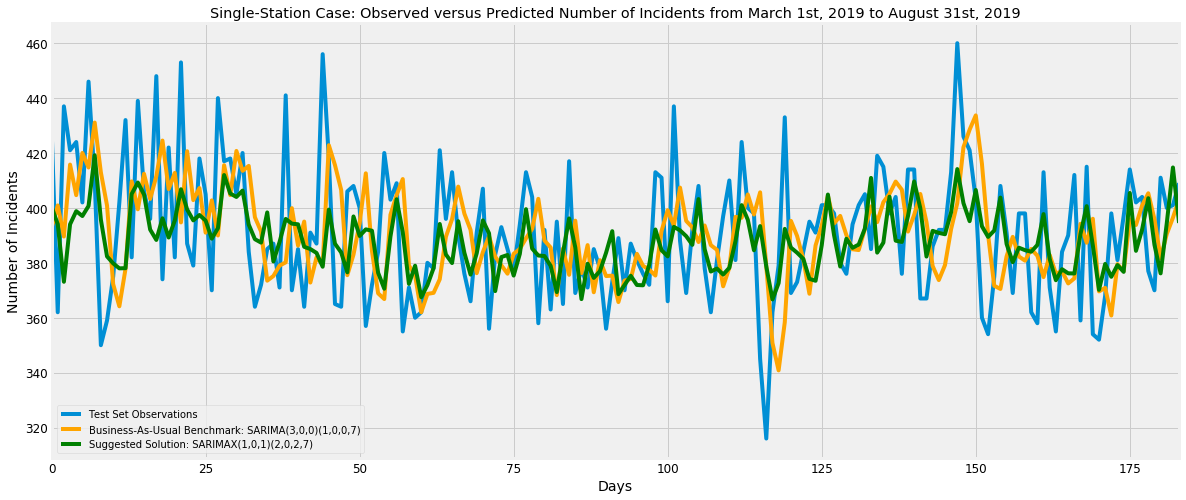

In [26]:
# Plot predictions against known values
rcParams['figure.figsize'] = 18, 8
title='Single-Station Case: Observed versus Predicted Number of Incidents from March 1st, 2019 to August 31st, 2019'
ylabel='Number of Incidents'
xlabel='Days'
date1 = datetime.date(2019,3,1)
date2 = datetime.date(2019,8,31)

#xticklabels = pd.period_range(date1, date2,freq='M').tolist()


ax = test_name.plot(x=xticklabels,legend=True,title=title, label='Test Set Observations' )
predictions_u_name.plot(x=xticklabels,legend=True, label='Business-As-Usual Benchmark: SARIMA(3,0,0)(1,0,0,7)',color='orange')
predictions_m_name.plot(x=xticklabels,legend=True, label='Suggested Solution: SARIMAX(1,0,1)(2,0,2,7)',color='green')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);